# Lomin Project - 이미지 회전 각도 예측

## Prediction angle
---


## 목표

#### 이미지 회전 학습을 통해 target 이미지가 어느정도 회전해 있는지 각도를 예측

---

## 사용이미지

주어진 합성 이미지 활용



---


# 데이터 전처리

### 신규 이미지는 xml 을 다시 만들어 줘야 함

In [238]:
DATA_PATH = 'D:/coding/data_set/lomin/train_copy2'

'D:/coding/data_set/lomin/train_copy2'

In [ ]:
# Annotation 새로 만들기 (한개만)
#https://junyoung-jamong.github.io/machine/learning/2019/01/23/%EB%B0%94%EC%9A%B4%EB%94%A9%EB%B0%95%EC%8A%A4%EB%A5%BC-%ED%8F%AC%ED%95%A8%ED%95%9C-%EC%9D%B4%EB%AF%B8%EC%A7%80-%EC%A6%9D%ED%8F%AD%EC%8B%9C%ED%82%A4%EA%B8%B0-with-imgaug.html

# 바운딩박스 복붙 (Annotation정보 읽기)
import os
import glob
import cv2
import xml.etree.ElementTree as ET

# Annotation 반복 만들기 (기본 0도)
def annotation_one_xml(origin_path, make_path):
    
    # 폴더 내 이미지 리스트
    # img_list = sorted(glob.glob(origin_path + '/*'))

    # for i in img_list:
        # File = open(origin_path + i.split('\\')[1].split('.')[0] + ".xml", "w")
        File = open(origin_path + make_path.split('/')[-1].split('.')[0] + ".xml", "w")
        print("""<annotation>
    <folder>test_after</folder>
    <filename>{}.png</filename>
    <path>D:\coding\data_set\lomin\\train_copy\\train\\{}.png</path>
    <source>
        <database>Unknown</database>
    </source>
    <size>
        <width>1654</width>
        <height>2339</height>
        <depth>1</depth>
    </size>
    <segmented>0</segmented>
    <object>
        <name>0</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <difficult>0</difficult>
        <bndbox>
            <xmin>355</xmin>
            <ymin>503</ymin>
            <xmax>1299</xmax>
            <ymax>1836</ymax>
        </bndbox>
    </object>
</annotation>
        """.format(make_path.split('/')[-1].split('.')[0], make_path.split('/')[-1].split('.')[0]), file=File)

        File.close()

---

In [ ]:
## Annotation 읽기

# https://junyoung-jamong.github.io/machine/learning/2019/01/23/%EB%B0%94%EC%9A%B4%EB%94%A9%EB%B0%95%EC%8A%A4%EB%A5%BC-%ED%8F%AC%ED%95%A8%ED%95%9C-%EC%9D%B4%EB%AF%B8%EC%A7%80-%EC%A6%9D%ED%8F%AD%EC%8B%9C%ED%82%A4%EA%B8%B0-with-imgaug.html

import xml.etree.ElementTree as ET

def read_anntation(xml_file: str):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    bounding_box_list = []

    file_name = root.find('filename').text
    for obj in root.iter('object'):

        object_label = obj.find("name").text
        for box in obj.findall("bndbox"):
            x_min = int(box.find("xmin").text)
            y_min = int(box.find("ymin").text)
            x_max = int(box.find("xmax").text)
            y_max = int(box.find("ymax").text)

        bounding_box = [object_label, x_min, y_min, x_max, y_max]
        bounding_box_list.append(bounding_box)

    return bounding_box_list, file_name

In [ ]:
## 이미지 데이터 읽기 (파일 1개 읽기)

from os import listdir
import cv2
import numpy as np

def read_one_train_dataset(dir, file):
    images = []
    annotations = []

    if 'jpg' in file.lower() or 'png' in file.lower():
        images.append(cv2.imread(dir + file, 1))
        annotation_file = file.replace(file.split('.')[-1], 'xml')
        bounding_box_list, file_name = read_anntation(dir + annotation_file)
        annotations.append((bounding_box_list, annotation_file, file_name))

    # images = np.array(images)

    return images, annotations

---

In [ ]:
## 폴더 생성 + 검은 배경 추가 + 360도 회전 + annotation 추가 (회전각에 대한 박스 변경)

import os
import glob
import cv2
import imgaug as ia
from imgaug import augmenters as iaa
from pascal_voc_writer import Writer
import xml.etree.ElementTree as ET

# input_path = 'D:/coding/data_set/lomin/train_copy2/train' 
# output_path = 'D:/coding/data_set/lomin/train_copy2/train_angle/'

# img_count = 몇장 씩 => 360도 
def lotation_img(img_count, input_path, output_path):
    
    # 폴더 만들기
    os.makedirs(output_path)

    img_list = sorted(glob.glob(input_path + '/*'))

    for j in range(0, 360):
        # 전체 이미지 중 랜덤하게 추출
        random_list = np.random.choice(img_list, img_count, replace=False)
        
        for i in random_list:
            # print(i.split('\\')[1].split('.')[0])
            src = cv2.imread(i, cv2.IMREAD_COLOR)
            height, width, channel = src.shape
            
            ##                                  중심점(center), 각도(angle), 비율(scale)
            matrix = cv2.getRotationMatrix2D((width/2, height/2), -j, 0.57)
            # 비율 : 가로길이 / 대각선

            dst = cv2.warpAffine(src, matrix, (width, height))

            # 변경 이미지 저장 (파일명_각도)
            fname_angle = i.split('\\')[1].split('.')[0] + '_' + str(j) + '.png'
            cv2.imwrite(output_path + fname_angle, dst)
            
            # cv2.imwrite(output_path + i.split('\\')[1].split('.')[0] + '.png', dst)
            
            # annotation 파일 추가 (기본 0도 파일만 생성)
            xml_path = output_path + fname_angle
            annotation_one_xml(output_path, xml_path)
            
            # 생성된 이미지 기반으로 이미지정보, xml 정보를 읽음
            images, annotations = read_one_train_dataset(output_path, fname_angle)

            image = images[0]
            boxes = annotations[0][0]

            # 추출된 xml 정보 중 bbox 좌표만 추출
            ia_bounding_boxes = []
            for box in boxes:
                ia_bounding_boxes.append(ia.BoundingBox(x1=box[1], y1=box[2], x2=box[3], y2=box[4]))

            bbs = ia.BoundingBoxesOnImage(ia_bounding_boxes, shape=image.shape)
            
            # 이미지 변환 각종 옵션들 (현재는 회전만 함 - 사용시 아래의 이미지 생성을 사용해야 함)
            seq = iaa.Sequential([
                # iaa.Multiply((1.2, 1.5)),
                iaa.Affine(
                    # translate_px={"x": 40, "y": 60},
                    # scale=(0.5, 0.7),
                    rotate = int(j)
                )
            ])

            seq_det = seq.to_deterministic()

            image_aug = seq_det.augment_images([image])[0]
            bbs_aug = seq_det.augment_bounding_boxes([bbs])[0]

            # new_image_file = output_path + annotations[0][2].split('.')[0] + '_' + str(j) + "." + annotations[0][2].split('.')[1]
            new_image_file = output_path + annotations[0][2].split('.')[0] + "." + annotations[0][2].split('.')[1]
            # 이미지 파일 생성 (이미지 파일은 위에서 이미 생성 했음)
            # cv2.imwrite(new_image_file, image_aug)

            h, w = np.shape(image_aug)[0:2]
            voc_writer = Writer(new_image_file, w, h)

            # xml 파일 내부 속성 바꿈
            for i in range(len(bbs_aug.bounding_boxes)):
                bb_box = bbs_aug.bounding_boxes[i]
                # name (label) , x1, x2, y1, y2 값 바꿈
                voc_writer.addObject(j, int(bb_box.x1), int(bb_box.y1), int(bb_box.x2), int(bb_box.y2))

            # annotation 파일 내부 좌표를 변경함
            voc_writer.save(output_path + annotations[0][1].split('.')[0] + "." + annotations[0][1].split('.')[1])


In [237]:
os.path.join(DATA_PATH, 'train/')

'D:/coding/data_set/lomin/train_copy2\\train/'

In [236]:
ouput_path

NameError: name 'ouput_path' is not defined

In [ ]:
%%time

## 전처리 실행 (train)

input_path = os.path.join(DATA_PATH, 'train/')
output_path = os.path.join(DATA_PATH, 'train_angle/')

lotation_img(30, input_path, output_path)

Wall time: 21min 59s


---

# 모델 구성

In [4]:
import os
import gc
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# ## 드라이브 마운트

# from google.colab import drive
# drive.mount('/content/drive/')

### 파일 로드 및 확인

In [5]:
os.listdir(DATA_PATH)

['test',
 'test_angle',
 'test_crop',
 'test_crop1',
 'train',
 'train_angle',
 'train_crop']

---
(통합폴더 (패스))

In [6]:
import pandas as pd

# train 데이터 프레임 만들기
df_train = pd.DataFrame(columns=['img_file', 'bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2', 'class'])
df_test = pd.DataFrame(columns=['img_file', 'bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2', 'class'])


In [7]:
%%time
## 테이터 프레임에 xml 정보 추가 (통합 폴더)

import imgaug as ia
import os
from imgaug import augmenters as iaa
import xml.etree.ElementTree as ET

ia.seed(1)

# train dir
dir = DATA_PATH + '/train_angle/'

# test dir
# dir = DATA_PATH + '/test_angle/'

     
## 폴더안에 있는 모든 xml 파일 이름 가져오기
file_list = os.listdir(dir)
xml_list = []

for file in file_list:
    if '.xml' in file:
        xml_list.append(file)

## 모든 .xml파일에 대해 수정
for xml_file in xml_list:
    target_path = dir + xml_file

    tree = ET.parse(target_path)
    root = tree.getroot()
    # bounding_box_list = []

    file_name = root.find('filename').text
    object_label = root.find('object/name').text
    x_min = int(root.find('object/bndbox/xmin').text)
    y_min = int(root.find('object/bndbox/ymin').text)
    x_max = int(root.find('object/bndbox/xmax').text)
    y_max = int(root.find('object/bndbox/ymax').text)
            
    # bounding_box = [file_name, x_min, y_min, x_max, y_max, object_label]

    # trian 데이터 프레임에 추가하기
    df_train = df_train.append(pd.DataFrame([[file_name, x_min, y_min, x_max, y_max, object_label]], 
                                            columns=['img_file', 'bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2', 'class']),
                                            ignore_index=True)
    
    # # val 데이터 프레임에 추가하기
    # df_test = df_test.append(pd.DataFrame([[file_name, x_min, y_min, x_max, y_max, object_label]], 
    #                                         columns=['img_file', 'bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2', 'class']),
    #                                         ignore_index=True)

Wall time: 15.9 s


In [8]:
%%time
## 테이터 프레임에 xml 정보 추가 (통합 폴더)

import imgaug as ia
import os
from imgaug import augmenters as iaa
import xml.etree.ElementTree as ET

ia.seed(1)

# train dir
# dir = DATA_PATH + '/train_angle/'

# test dir
dir = DATA_PATH + '/test_angle/'

     
## 폴더안에 있는 모든 xml 파일 이름 가져오기
file_list = os.listdir(dir)
xml_list = []

for file in file_list:
    if '.xml' in file:
        xml_list.append(file)

## 모든 .xml파일에 대해 수정
for xml_file in xml_list:
    target_path = dir + xml_file

    tree = ET.parse(target_path)
    root = tree.getroot()
    # bounding_box_list = []

    file_name = root.find('filename').text
    object_label = root.find('object/name').text
    x_min = int(root.find('object/bndbox/xmin').text)
    y_min = int(root.find('object/bndbox/ymin').text)
    x_max = int(root.find('object/bndbox/xmax').text)
    y_max = int(root.find('object/bndbox/ymax').text)
            
    # bounding_box = [file_name, x_min, y_min, x_max, y_max, object_label]

    # # trian 데이터 프레임에 추가하기
    # df_train = df_train.append(pd.DataFrame([[file_name, x_min, y_min, x_max, y_max, object_label]], 
    #                                         columns=['img_file', 'bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2', 'class']),
    #                                         ignore_index=True)
    
    # val 데이터 프레임에 추가하기
    df_test = df_test.append(pd.DataFrame([[file_name, x_min, y_min, x_max, y_max, object_label]], 
                                            columns=['img_file', 'bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2', 'class']),
                                            ignore_index=True)

Wall time: 1.33 s


---

In [9]:
df_train

,img_file,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class
0,000000_64.png,21,453,1632,1885,64
1,000001_141.png,40,354,1613,1984,141
2,000001_187.png,277,450,1376,1888,187
3,000002_149.png,79,355,1574,1983,149
4,000002_23.png,132,371,1521,1967,23
...,...,...,...,...,...,...
10795,011937_339.png,254,268,1613,1850,339
10796,011939_144.png,52,353,1599,1986,144
10797,011943_45.png,21,364,1631,1974,45
10798,011947_18.png,172,389,1481,1949,18


In [10]:
df_test

,img_file,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class
0,000004_36.png,53,352,1600,1986,36
1,000009_26.png,110,363,1543,1975,26
2,000038_93.png,136,663,1517,1675,93
3,000042_96.png,114,630,1539,1708,96
4,000043_138.png,30,358,1623,1980,138
...,...,...,...,...,...,...
1075,011908_18.png,172,389,1481,1949,18
1076,011908_304.png,10,405,1643,1933,304
1077,011915_280.png,88,588,1564,1749,280
1078,011933_359.png,349,490,1316,1839,359


---

In [11]:
# 이미지 폴더 경로
TRAIN_IMG_PATH = os.path.join(DATA_PATH, 'train_angle')
TEST_IMG_PATH = os.path.join(DATA_PATH, 'test_angle')

# IMG_SIZE
img_size = (224, 224)

___

## 이미지 확인

In [12]:
import PIL
from PIL import ImageDraw

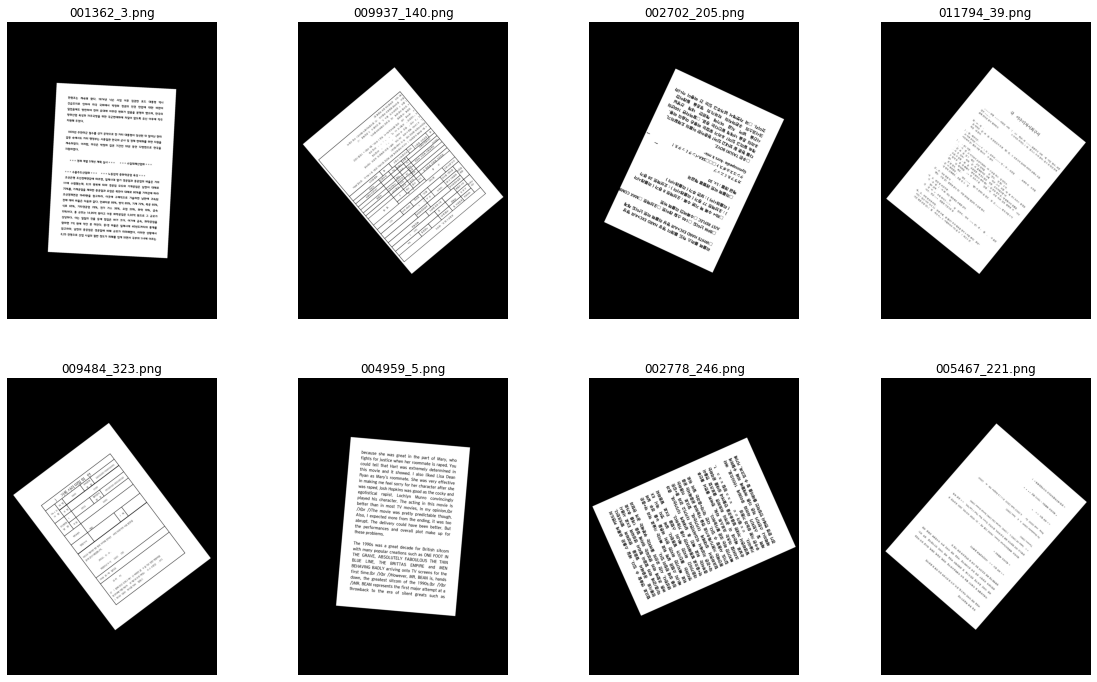

In [86]:

## 랜덤하게 8장 사진을 확인
tmp_imgs = df_train['img_file'].sample(n=8, random_state=42)
plt.figure(figsize=(20, 12))

for num, f_name in enumerate(tmp_imgs):
    img = PIL.Image.open(os.path.join(TRAIN_IMG_PATH, f_name))
    plt.subplot(2, 4, num + 1)
    plt.title(f_name)
    plt.imshow(img)
    plt.axis('off')

In [13]:
## 박스 처리

def draw_rect(drawcontext, pos, outline=None, width=0):
    (x1, y1) = (pos[0], pos[1])
    (x2, y2) = (pos[2], pos[3])
    points = (x1, y1), (x2, y1), (x2, y2), (x1, y2), (x1, y1)
    drawcontext.line(points, fill=outline, width=width)

In [14]:
## train data 바운딩 처리

def make_boxing_img_train(img_name) :
    PATH = TRAIN_IMG_PATH
    data = df_train

    img = PIL.Image.open(os.path.join(PATH, img_name))
    pos = data.loc[data["img_file"] == img_name, \
                   ['bbox_x1','bbox_y1', 'bbox_x2', 'bbox_y2']].values.reshape(-1)
    draw = ImageDraw.Draw(img)
    draw_rect(draw, pos, outline='red', width=10)
    
    return img

In [57]:
## test data 바운딩 처리

def make_boxing_img_test(img_name) :
    PATH = TEST_IMG_PATH
    data = df_test

    img = PIL.Image.open(os.path.join(PATH, img_name))
    pos = data.loc[data["img_file"] == img_name, \
                   ['bbox_x1','bbox_y1', 'bbox_x2', 'bbox_y2']].values.reshape(-1)
    draw = ImageDraw.Draw(img)
    draw_rect(draw, pos, outline='red', width=10)
    
    return img

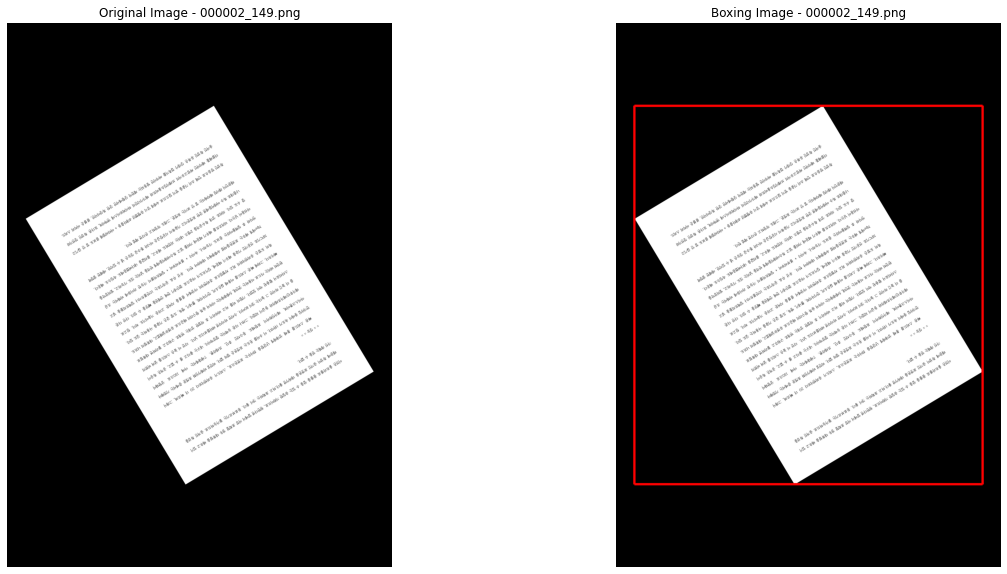

In [90]:
## 확인하고 싶은 이미지 번호 입력
f_name = "000002_149.png"

plt.figure(figsize=(20,10))

## 원본 이미지
plt.subplot(1, 2, 1)
origin_img = PIL.Image.open(os.path.join(TRAIN_IMG_PATH, f_name))
plt.title("Original Image - {}".format(f_name))
plt.imshow(origin_img)
plt.axis('off')

## Bounding Box 처리 된 이미지
plt.subplot(1, 2, 2)
boxing = make_boxing_img_train(f_name)
plt.title("Boxing Image - {}".format(f_name))
plt.imshow(boxing)
plt.axis('off')

plt.show()

## 이미지 resize 하기

In [15]:
## train 이미지 resize

def crop_resize_boxing_img_train(img_name, margin=16, size=(224, 224)) :
    PATH = TRAIN_IMG_PATH
    data = df_train
        
    img = PIL.Image.open(os.path.join(PATH, img_name))
    # pos = data.loc[data["img_file"] == img_name, \
    #                ['bbox_x1','bbox_y1', 'bbox_x2', 'bbox_y2']].values.reshape(-1)
    
    pos = data.loc[data["img_file"] == img_name, \
                ['bbox_x1','bbox_y1', 'bbox_x2', 'bbox_y2']].values.reshape(-1)

    width, height = img.size
    x1 = max(0, pos[0] - margin)
    y1 = max(0, pos[1] - margin)
    x2 = min(pos[2] + margin, width)
    y2 = min(pos[3] + margin, height)

    return img.crop((x1,y1,x2,y2)).resize(size)

In [16]:
## test 이미지 resize

def crop_resize_boxing_img_test(img_name, margin=16, size=img_size) :
    PATH = TEST_IMG_PATH
    data = df_test
        
    img = PIL.Image.open(os.path.join(PATH, img_name))
    
    # pos = data.loc[data["img_file"] == img_name, \
    #                ['bbox_x1','bbox_y1', 'bbox_x2', 'bbox_y2']].values.reshape(-1)

    pos = data.loc[data["img_file"] == img_name, \
                   ['bbox_x1','bbox_y1', 'bbox_x2', 'bbox_y2']].values.reshape(-1)

    width, height = img.size
    x1 = max(0, pos[0] - margin)
    y1 = max(0, pos[1] - margin)
    x2 = min(pos[2] + margin, width)
    y2 = min(pos[3] + margin, height)

    return img.crop((x1,y1,x2,y2)).resize(size)

In [92]:
%%time
## 폴더를 만들고 박스에 맞춰 이미지 resize (train data) 후 폴더에 저장

os.makedirs(os.path.join(DATA_PATH,'train_crop'))

for i, row in df_train.iterrows():
    cropped = crop_resize_boxing_img_train(row['img_file'])
    cropped.save(f"{os.path.join(DATA_PATH, 'train_crop')}/{row['img_file']}")

Wall time: 9min 3s


In [158]:
%%time
## 폴더를 만들고 박스에 맞춰 이미지 resize (test data) 후 폴더에 저장

os.makedirs(os.path.join(DATA_PATH, 'test_crop'))

for i, row in df_test.iterrows():
    cropped = crop_resize_boxing_img_test(row['img_file'])
    cropped.save(f"{os.path.join(DATA_PATH,'test_crop')}/{row['img_file']}")

Wall time: 54.5 s


In [17]:
## crop 이미지 경로 설정

TRAIN_CROP_PATH = os.path.join(DATA_PATH, 'train_crop')
TEST_CROP_PATH = os.path.join(DATA_PATH, 'test_crop')

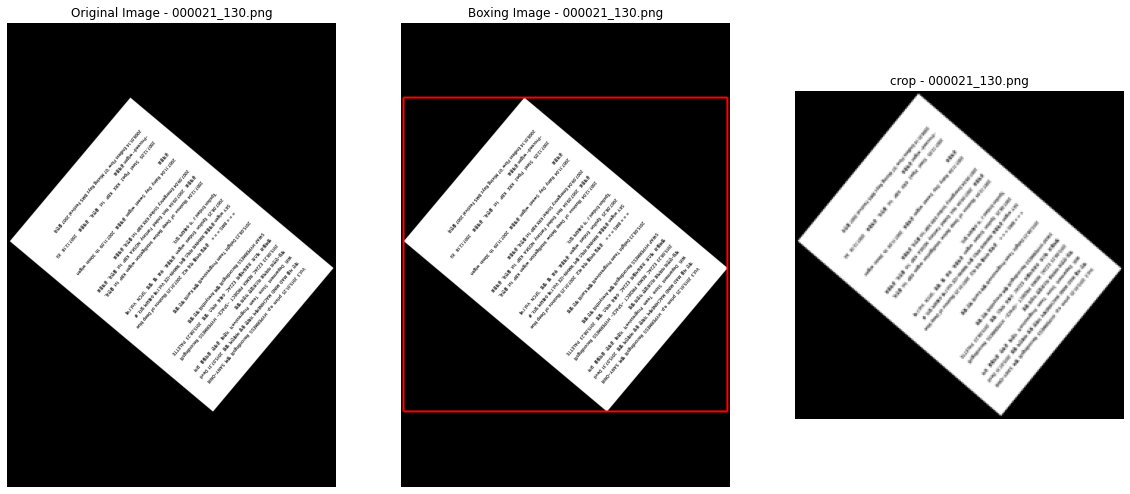

In [95]:
## 확인하고 싶은 이미지 번호 입력
f_name = "000021_130.png"

plt.figure(figsize=(20,10))

## 원본 이미지
plt.subplot(1, 3, 1)
origin_img = PIL.Image.open(os.path.join(TRAIN_IMG_PATH, f_name))
plt.title("Original Image - {}".format(f_name))
plt.imshow(origin_img)
plt.axis('off')

## Bounding Box 처리 된 이미지
plt.subplot(1, 3, 2)
boxing = make_boxing_img_train(f_name)
plt.title("Boxing Image - {}".format(f_name))
plt.imshow(boxing)
plt.axis('off')

## crop 된 이미지
plt.subplot(1, 3, 3)
crop = PIL.Image.open(os.path.join(TRAIN_CROP_PATH, f_name))
plt.title("crop - {}".format(f_name))
plt.imshow(crop)
plt.axis('off')

plt.show()

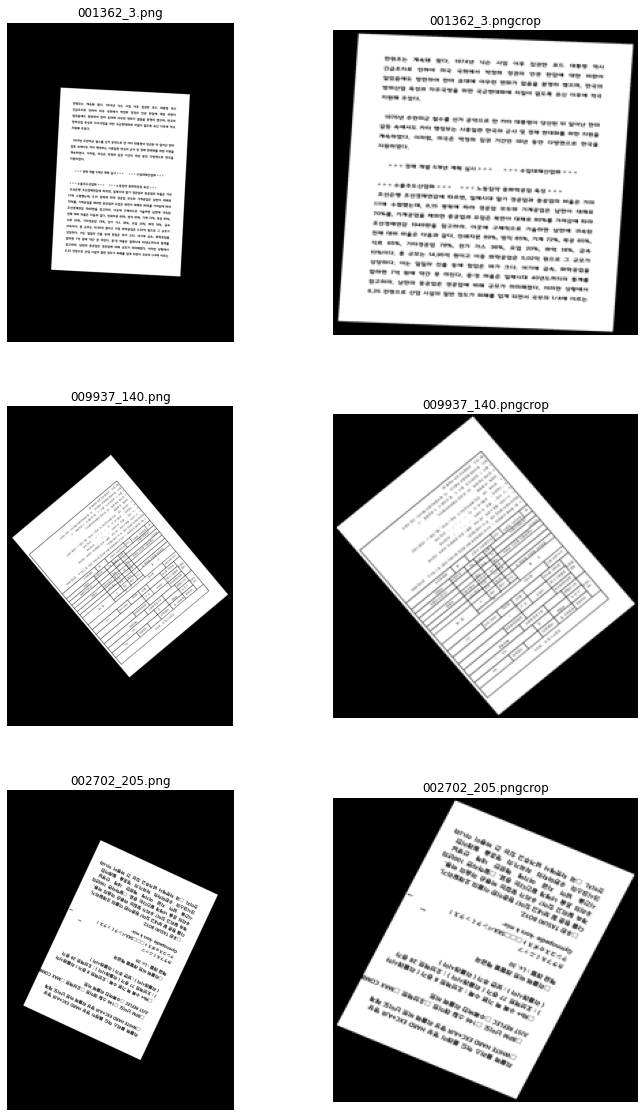

In [96]:
## crop 된 이미지 확인

tmp_imgs = df_train['img_file'].sample(n=3, random_state=42)
# tmp_imgs = df_train['img_file'][100:103]
plt.figure(figsize=(12,20))

for num, f_name in enumerate(tmp_imgs):
    img = PIL.Image.open(os.path.join(TRAIN_IMG_PATH, f_name))
    plt.subplot(3, 2, 2*num + 1)
    plt.title(f_name)
    plt.imshow(img)
    plt.axis('off')
    
    img = PIL.Image.open(os.path.join(TRAIN_CROP_PATH, f_name))
    plt.subplot(3, 2, 2*num + 2)
    plt.title(f_name + "crop")
    plt.imshow(img)
    plt.axis('off')

## 모델링

In [42]:
## train, val, test set 나눠주기

from sklearn.model_selection import train_test_split

## class 를 string 으로 바꿔주고 좌표들을 지워준다.
df_train["class"] = df_train["class"].astype('str')

df_train = df_train[['img_file', 'class']]
df_test = df_test[['img_file']]

its = np.arange(df_train.shape[0])
train_idx, val_idx = train_test_split(its, train_size = 0.7, random_state=42)

X_train = df_train.iloc[train_idx, :]
X_val = df_train.iloc[val_idx, :]

print(X_train.shape)
print(X_val.shape)
print(df_test.shape)

(7559, 2)
(3241, 2)
(1080, 1)


C:\ProgramData\Anaconda3\envs\lomin\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [43]:
len(X_val['class'].unique())

360

모델링은 keras의 generator 들을 이용하면 쉽게 만들 수 있다.

In [19]:
import tensorflow as tf
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [44]:
## 데이터 제네레이터 구성하기

## 파라미터 설정
## https://keras.io/api/preprocessing/image/

nb_train_samples = len(X_train)
nb_validation_samples = len(X_val)
nb_test_samples = len(df_test)
batch_size = 32

In [45]:
## 입력이미지의 데이터 증강 (Data Augmentation)
train_datagen = ImageDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.2,1.0],
    zoom_range=[0.5,0.1],
    preprocessing_function=preprocess_input
)

# val_datagen = ImageDataGenerator(rescale=1. / 255)
# train_datagen = ImageDataGenerator(rescale=1. / 255)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [46]:
## 제네레이터 설정
##.flow_from_dataframe
##.flow_from_directory

# Make Generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=X_train, 
    directory=TRAIN_CROP_PATH,
    x_col = 'img_file',
    y_col = 'class',
    target_size = img_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    seed=42
)

validation_generator = val_datagen.flow_from_dataframe(
    dataframe=X_val, 
    directory=TRAIN_CROP_PATH,
    x_col='img_file',
    y_col='class',
    target_size=img_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    directory=TEST_CROP_PATH,
    x_col='img_file',
    y_col=None,
    target_size= img_size,
    color_mode='rgb',
    class_mode=None,
    batch_size=batch_size,
    shuffle=False
)

Found 7559 validated image filenames belonging to 360 classes.
Found 3241 validated image filenames belonging to 360 classes.
Found 1080 validated image filenames.


In [23]:
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.applications.resnet_v2 import ResNet50V2

In [47]:
## MobileNet 으로  base model을 만든다.

# weights='imagenet' : 이미지 넷에 트레이닝 된 모델을 불러옴

IMG_SHAPE = img_size + (3, )

BaseModel = MobileNet(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)

# BaseModel = ResNet50(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)

# BaseModel = ResNet50V2(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)

model = Sequential()
model.add(BaseModel)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='sigmoid', kernel_initializer='he_normal'))
model.add(Dense(128, activation='sigmoid'))
model.add(Dense(64, activation='sigmoid'))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(16, activation='sigmoid'))
model.add(Dense(360, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1024)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_8 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_9 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_10 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_11 (Dense)             (None, 16)               

In [48]:
## 모델 컴파일 하기
from sklearn.metrics import f1_score

def micro_f1(y_true, y_pred):
    return f1_score(y_true, y_pred, average='micro')

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [49]:
def get_steps(num_samples, batch_size):
    if (num_samples % batch_size) > 0 :
        return (num_samples // batch_size) + 1
    else :
        return num_samples // batch_size

In [50]:
## 체크포인트 설정

## monitor : val_acc 를 기준으로 저장한다.
## verbose : 1 일 경우 모델이 저장 됨을 표시

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

filepath = "my_mobilenet_model_{val_acc:.2f}_{val_loss:.4f}.h5"

checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True)
#es = EarlyStopping(monitor='val_acc', min_delta=0, patience=3, verbose=1, mode='auto')

callbackList = [checkpoint]

In [51]:
%%time

history = model.fit_generator(
    train_generator,
    steps_per_epoch = get_steps(nb_train_samples, batch_size),
    epochs=150,
    validation_data = validation_generator,
    validation_steps = get_steps(nb_validation_samples, batch_size),
    callbacks = callbackList
)
gc.collect()

Epoch 1/150
237/237 [==============================] - ETA: 0s - loss: 5.8960 - acc: 0.0030
Epoch 00001: val_acc improved from -inf to 0.00154, saving model to my_mobilenet_model_0.00_5.8953.h5
237/237 [==============================] - 82s 346ms/step - loss: 5.8960 - acc: 0.0030 - val_loss: 5.8953 - val_acc: 0.0015
Epoch 2/150
237/237 [==============================] - ETA: 0s - loss: 5.8856 - acc: 0.0026
Epoch 00002: val_acc did not improve from 0.00154
237/237 [==============================] - 75s 318ms/step - loss: 5.8856 - acc: 0.0026 - val_loss: 5.9046 - val_acc: 0.0015
Epoch 3/150
237/237 [==============================] - ETA: 0s - loss: 5.8714 - acc: 0.0033
Epoch 00003: val_acc improved from 0.00154 to 0.00185, saving model to my_mobilenet_model_0.00_5.9048.h5
237/237 [==============================] - 76s 320ms/step - loss: 5.8714 - acc: 0.0033 - val_loss: 5.9048 - val_acc: 0.0019
Epoch 4/150
237/237 [==============================] - ETA: 0s - loss: 5.8249 - acc: 0.0049
Epo

846

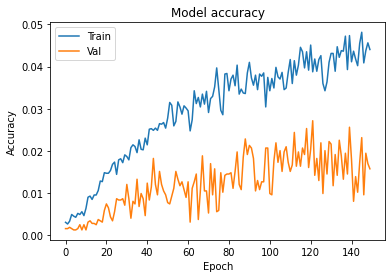

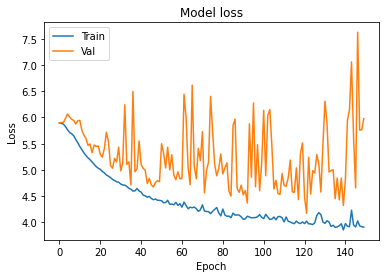

In [53]:
## 트레이닝 결과 곡선

## validation acc 곡선 그래프
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

## validation loss 곡선 그래프
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [54]:
## 저장된 모델 리스트 정렬

model_list = sorted([i for i in os.listdir() if "my_" in i])
model_list

['my_mobilenet_model_0.00_5.3261.h5',
 'my_mobilenet_model_0.00_5.6595.h5',
 'my_mobilenet_model_0.00_5.7523.h5',
 'my_mobilenet_model_0.00_5.8953.h5',
 'my_mobilenet_model_0.00_5.9048.h5',
 'my_mobilenet_model_0.00_5.9437.h5',
 'my_mobilenet_model_0.01_4.7122.h5',
 'my_mobilenet_model_0.01_4.9810.h5',
 'my_mobilenet_model_0.01_5.0843.h5',
 'my_mobilenet_model_0.01_5.2975.h5',
 'my_mobilenet_model_0.01_5.4579.h5',
 'my_mobilenet_model_0.02_4.5007.h5',
 'my_mobilenet_model_0.02_4.5723.h5',
 'my_mobilenet_model_0.02_4.7403.h5',
 'my_mobilenet_model_0.02_4.8317.h5',
 'my_mobilenet_model_0.02_4.8471.h5',
 'my_mobilenet_model_0.03_4.1722.h5',
 'my_mobilenet_model_0.03_5.3151.h5']

In [55]:
## BEST Model 선택

model.load_weights(model_list[-1])

In [56]:
%%time
## Best Model 적용

test_generator.reset()
prediction = model.predict_generator(
    generator = test_generator,
    steps = get_steps(nb_test_samples, batch_size),
    verbose=1
)

Instructions for updating:
Please use Model.predict, which supports generators.
34/34 [==============================] - 5s 138ms/step
Wall time: 5.23 s


## 확인작업

In [ ]:
## test 이미지 확인
f_name = "000009_26.png"

plt.figure(figsize=(20,10))

## 원본 이미지
plt.subplot(1, 3, 1)
origin_img = PIL.Image.open(os.path.join(TEST_IMG_PATH, f_name))
plt.title("Original Image - {}".format(f_name))
plt.imshow(origin_img)
plt.axis('off')

## Bounding Box 처리 된 이미지
plt.subplot(1, 3, 2)
boxing = make_boxing_img_test(f_name)
plt.title("Boxing Image - {}".format(f_name))
plt.imshow(boxing)
plt.axis('off')

## crop 된 이미지
plt.subplot(1, 3, 3)
crop = PIL.Image.open(os.path.join(TEST_CROP_PATH, f_name))
plt.title("crop - {}".format(f_name))
plt.imshow(crop)
plt.axis('off')

plt.show()

In [ ]:
## 분류한 이미지의 추정 class 와 모델
## id = 추정 class 
## name 추정 모델 명

as1 = submission[submission['img_file'] == f_name]
df_class[df_class['id'] == int(as1.iloc[0][1])]

In [51]:
as1

,img_file,class
3451,03452.jpg,149


# 간략 평가

In [ ]:
EVAL_PATH = 'E:/coding/Stanford Cars Dataset'

all100 = pd.read_csv(os.path.join(EVAL_PATH, 'test_class.csv'))
all100 = all100[['img_file', 'class']]

In [53]:
score = []
for i in range(0,8040):
    if int(all100['class'][i]) == int(submission['class'][i]) :
        score.append(1)
    else:
        score.append(0)
print('정확도 : ' , score.count(1)/8040)
print('맞은 갯수 : ' , score.count(1), ' / 8040')
print('안맞은 갯수 : ',score.count(0))

정확도 :  0.8259950248756219
맞은 갯수 :  6641  / 8040
안맞은 갯수 :  1399


## 각 class 별 정확도 확인

In [251]:
classlist = pd.read_csv(os.path.join(EVAL_PATH, 'class.csv'))

In [247]:
totalclass = pd.read_csv(os.path.join(EVAL_PATH, 'totalclass.csv'))

In [125]:
totalclass = totalclass.sort_values(by=["class"], ascending=[True])
totalclass

,img_file,class,class1,a1
4116,04117.jpg,1,1,1
3245,03246.jpg,1,1,1
1198,01199.jpg,1,1,1
8034,08035.jpg,1,1,1
75,00076.jpg,1,1,1
...,...,...,...,...
932,00933.jpg,196,196,1
621,00622.jpg,196,110,0
5965,05966.jpg,196,196,1
5722,05723.jpg,196,196,1


In [258]:
model_rate = pd.read_csv(os.path.join(EVAL_PATH, 'model_rate.csv'))
model_rate

,id,model,rate
0,71,Chevrolet Express Van 2007,0.057143
1,10,Aston Martin Virage Convertible 2012,0.333333
2,14,Audi TTS Coupe 2012,0.333333
3,104,Ferrari 458 Italia Coupe 2012,0.452381
4,23,Audi S4 Sedan 2012,0.461538
...,...,...,...
163,130,Hyundai Veloster Hatchback 2012,1.000000
164,141,Infiniti G Coupe IPL 2012,1.000000
165,152,Lamborghini Gallardo LP 570 4 Superleggera 2012,1.000000
166,154,Land Rover Range Rover SUV 2012,1.000000


In [263]:
## 50% 미만 class
model_rate[model_rate['rate'] < 0.5]

,id,model,rate
0,71,Chevrolet Express Van 2007,0.057143
1,10,Aston Martin Virage Convertible 2012,0.333333
2,14,Audi TTS Coupe 2012,0.333333
3,104,Ferrari 458 Italia Coupe 2012,0.452381
4,23,Audi S4 Sedan 2012,0.461538


---
---
---



## 추가 파일 확인

In [202]:
n_test = pd.DataFrame(columns=['img_file', 'bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2'])
re_test = pd.DataFrame(columns=['img_file', 'class'])

In [203]:
from PIL import Image

for i in os.listdir(N_TEST):
    img_open = Image.open(N_TEST + '/'+ i)
    img_array = np.asarray(img_open)
    file_name = i
    x_min = 0
    y_min = 0
    x_max = img_array.shape[1]
    y_max = img_array.shape[0]
    n_test = n_test.append(pd.DataFrame([[file_name, x_min, y_min, x_max, y_max]], 
                        columns=['img_file', 'bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2']),
                        ignore_index=True)
    re_test = re_test.append(pd.DataFrame([[file_name]], 
                        columns=['img_file']),
                        ignore_index=True)

In [161]:
n_test

,img_file,bbox_x1,bbox_y1,bbox_x2,bbox_y2
0,00000007.jpg,0,0,3492,4656
1,000001.png,0,0,1751,2334
2,00000315.jpg,0,0,3492,4656
3,00000329.jpg,0,0,3492,4656
4,000006.png,0,0,1104,2334
...,...,...,...,...,...
95,03_20210519_073208.jpg,0,0,4032,3024
96,fix00000661.jpg,0,0,3024,4032
97,fix00000725.jpg,0,0,3024,4032
98,fix00000761.jpg,0,0,3024,4032


In [162]:
re_test
# re_test.head(50)
# re_test.tail(50)

,img_file,class
0,00000007.jpg,NaN
1,000001.png,NaN
2,00000315.jpg,NaN
3,00000329.jpg,NaN
4,000006.png,NaN
...,...,...
95,03_20210519_073208.jpg,NaN
96,fix00000661.jpg,NaN
97,fix00000725.jpg,NaN
98,fix00000761.jpg,NaN


In [163]:
N_TEST = os.path.join(DATA_PATH, 'test_dj')
# n_test = pd.read_csv(os.path.join(DATA_PATH, 'test_dj.csv'))

In [183]:
N_TEST

'D:/coding/data_set/lomin/train_copy2\\test_dj'

In [164]:
n_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [184]:
nb_n_test_samples = len(os.listdir(N_TEST))

In [186]:
n_test_generator = n_test_datagen.flow_from_dataframe(
    dataframe=n_test,
    directory=N_TEST,
    x_col='img_file',
    y_col=None,
    target_size= img_size,
    color_mode='rgb',
    class_mode=None,
    batch_size=batch_size,
    shuffle=False
)

Found 100 validated image filenames.


In [187]:
%%time
## Best Model 적용

n_test_generator.reset()
prediction = model.predict_generator(
    generator = n_test_generator,
    steps = get_steps(nb_n_test_samples, batch_size),
    verbose=1
)

4/4 [==============================] - 4s 965ms/step
Wall time: 7.7 s


## 추가 결과표 작성

In [206]:
## 결과를 표로 작성

predicted_class_indices=np.argmax(prediction, axis=1)

# Generator class dictionary mapping
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

# # submission2 = pd.read_csv(os.path.join(DATA_PATH, 'sample_submission2.csv'))
# submission2 = re_test
# submission2["class"] = predictions



# # submission2.to_csv("submission2.csv", index=False)
# submission2.head()

for i in range(len(os.listdir(N_TEST))) :
    re_test['class'][i] = predictions[i]

re_test

,img_file,class
0,00000007.jpg,173
1,000001.png,173
2,00000315.jpg,156
3,00000329.jpg,173
4,000006.png,173
...,...,...
95,03_20210519_073208.jpg,271
96,fix00000661.jpg,342
97,fix00000725.jpg,92
98,fix00000761.jpg,173


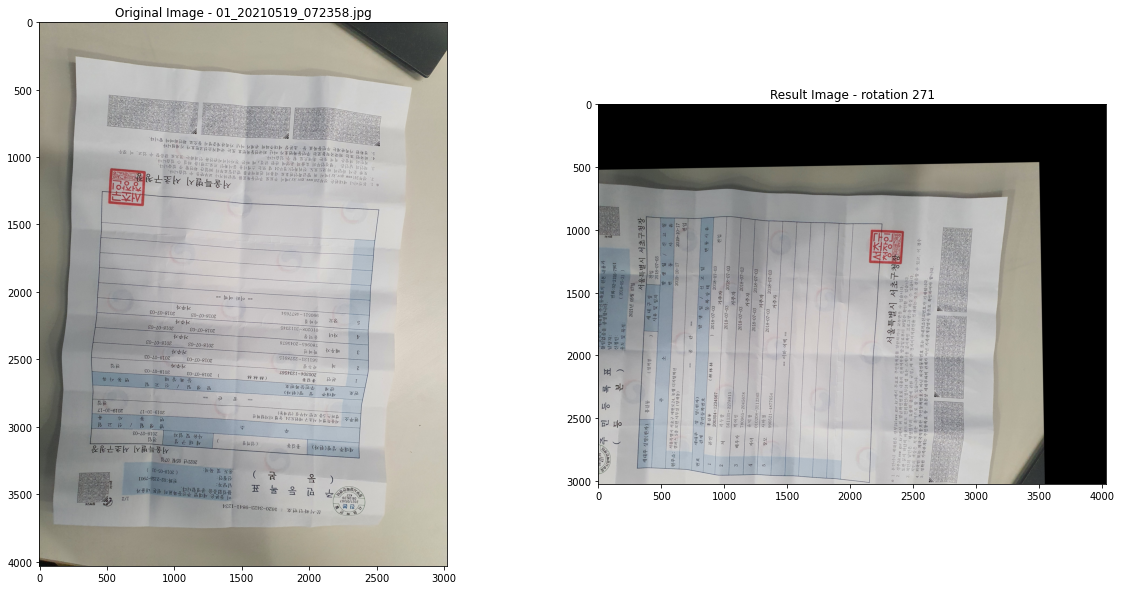

In [233]:
import cv2
import matplotlib.pyplot as plt

k = 55
ro_angle = int(re_test['class'][k])
f_name = os.listdir(N_TEST)[k]

plt.figure(figsize=(20,10))

img_rgb = cv2.imread(os.path.join(N_TEST, f_name))
img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)
h, w, c = img_rgb.shape

ro_center = int(w/2), int(h/2) # 정수
new_h, new_w = h, w

img_ro = cv2.getRotationMatrix2D(ro_center, ro_angle, 1) # 1은 확대/축소값
re_ro = cv2.warpAffine(img_rgb, img_ro, (new_h, new_w))

# 출력
plt.subplot(1, 2, 1) # 1행 2열에서 1번째 열
plt.title("Original Image - {}".format(f_name))
plt.imshow(img_rgb)

plt.subplot(1, 2, 2) # 1행 2열에서 2번째 열
plt.title("Result Image - rotation {}".format(ro_angle))
plt.imshow(re_ro)

plt.show()
